In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch 
import torch.nn as nn
import optuna
import optuna.visualization as vis
import joblib
# Set the current directory and utilities path
#current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utilities')

# Change the working directory to the notebook's directory
os.chdir(current_dir)

# Modify the module search path to include utilities directory
sys.path.insert(0, utilities_dir)

# Import Functions
from analytical_solution_functions import sound_hard_circle_calc 
from analytical_solution_functions import mask_displacement
from analytical_solution_functions import calculate_relative_errors
from pinns_solution_functions import generate_points
from pinns_solution_functions import MLP
from pinns_solution_functions import init_weights
from pinns_solution_functions import train_adam
from pinns_solution_functions import train_lbfgs
from pinns_solution_functions import initialize_and_load_model
from pinns_solution_functions import predict_displacement_pinns
from pinns_solution_functions import process_displacement_pinns

/home/orincon/miniconda3/envs/comparative-pinns-bem-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
# Parameters
r_i = np.pi / 4  # Inner radius
l_e = np.pi  # Outer radius
side_length = 2 * l_e  # Side length of the square
k = 3.0  # Wave number
n_Omega_P = 10_000  # Number of points inside the annular region
n_Gamma_I = 100  # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 250  # Number of points on the outer boundary (r = r_e)
n_grid = 501 # Number of grid points in x and y 

# Create a grid of points in the domain
Y, X = np.mgrid[-l_e:l_e:n_grid*1j, -l_e:l_e:n_grid*1j]

# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_inc_exact = mask_displacement(R_exact, r_i, l_e, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_i, l_e, u_scn_exact)
u_exact = mask_displacement(R_exact, r_i, l_e, u_exact)

# Default to CUDA if available, otherwise CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if not os.path.exists('datos'):
    os.makedirs('datos')

 
if not os.path.exists('models_iters'):
    os.mkdir('models_iters')

# Custom sine activation
class Sine(nn.Module):
    def forward(self, x):
        return torch.sin(x)

In [ ]:
# %%% -------------------------------------------------------------------------
# Optuna objective function
# -----------------------------------------------------------------------------
def objective(trial):
    results = []
    iter_train = 0

    # ---- Hyperparameters to optimize ----
    adam_lr        = trial.suggest_categorical("adam_lr", [1e-2, 1e-3, 1e-4])
    hidden_layers_ = trial.suggest_categorical("hidden_layers", [1, 2, 3])
    hidden_units_  = trial.suggest_categorical("hidden_units", [25, 50, 75])
    activation_str = trial.suggest_categorical("activation", ["Tanh", "Sigmoid", "Sine"])

    # ---- Iterations setup ----
    adam_fraction = 0.5
    total_iter    = 1_000
    adam_iters    = int(total_iter * adam_fraction)
    lbfgs_iters   = total_iter - adam_iters

    # ---- Activation function ----
    if activation_str == "Tanh":
        activation_function_ = nn.Tanh()
    elif activation_str == "ReLU":
        activation_function_ = nn.ReLU()
    elif activation_str == "Sigmoid":
        activation_function_ = nn.Sigmoid()
    elif activation_str == "Sine":
        activation_function_ = Sine()

    # ---- Generate training points ----
    x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, \
    x_bottom, y_bottom, x_top, y_top = generate_points(
        n_Omega_P, side_length, r_i, n_Gamma_I, n_Gamma_E
    )

    # ---- Build and initialize model ----
    model = MLP(
        input_size=2,
        output_size=2,
        hidden_layers=hidden_layers_,
        hidden_units=hidden_units_,
        activation_function=activation_function_,
    ).to(device)
    model.apply(init_weights)

    # ---- Train with Adam ----
    start_time_adam = time.time()
    train_adam(
        model, x_f, y_f, x_inner, y_inner, x_left, y_left,
        x_right, y_right, x_bottom, y_bottom, x_top, y_top,
        k, iter_train, results, adam_lr, num_iter=adam_iters
    )
    adam_training_time = time.time() - start_time_adam

    # ---- Train with L-BFGS ----
    start_time_lbfgs = time.time()
    train_lbfgs(
        model, x_f, y_f, x_inner, y_inner, x_left, y_left,
        x_right, y_right, x_bottom, y_bottom, x_top, y_top,
        k, iter_train, results, 1, num_iter=lbfgs_iters
    )
    lbfgs_training_time = time.time() - start_time_lbfgs

    # ---- Evaluate model ----
    u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns = predict_displacement_pinns(
        model, l_e, r_i, k, n_grid
    )

    u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns, \
    diff_uscn_amp_pinns, diff_u_scn_phase_pinns = process_displacement_pinns(
        model, l_e, r_i, k, n_grid, X, Y, R_exact, u_scn_exact
    )

    rel_error_uscn_amp_pinns, rel_error_uscn_phase_pinns, \
    max_diff_uscn_amp_pinns, min_diff_uscn_amp_pinns, \
    max_diff_u_phase_pinns, min_diff_u_phase_pinns = calculate_relative_errors(
        u_scn_exact, u_exact, diff_uscn_amp_pinns,
        diff_u_scn_phase_pinns, R_exact, r_i
    )

    # ---- Final metric ----
    mean_rel_error_pinns = (rel_error_uscn_amp_pinns + rel_error_uscn_phase_pinns) / 2

    return mean_rel_error_pinns


In [59]:
# ---- Run the study ----

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best trial:")
best_trial = study.best_trial
print(f"  Value (mean error): {best_trial.value:.3e}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-08-28 10:44:41,858] A new study created in memory with name: no-name-0239b11d-1c34-4f70-b04d-8cfe99db34d0
[I 2025-08-28 10:45:11,011] Trial 0 finished with value: 0.9054624858887865 and parameters: {'adam_lr': 0.01, 'hidden_layers': 1, 'hidden_units': 50, 'activation': 'Sigmoid'}. Best is trial 0 with value: 0.9054624858887865.
[I 2025-08-28 10:45:53,423] Trial 1 finished with value: 0.7274011277997547 and parameters: {'adam_lr': 0.001, 'hidden_layers': 2, 'hidden_units': 50, 'activation': 'Tanh'}. Best is trial 1 with value: 0.7274011277997547.
[I 2025-08-28 10:46:29,368] Trial 2 finished with value: 0.8568251628042654 and parameters: {'adam_lr': 0.001, 'hidden_layers': 1, 'hidden_units': 75, 'activation': 'Tanh'}. Best is trial 1 with value: 0.7274011277997547.
[I 2025-08-28 10:47:20,598] Trial 3 finished with value: 0.6308720393586729 and parameters: {'adam_lr': 0.001, 'hidden_layers': 3, 'hidden_units': 50, 'activation': 'Tanh'}. Best is trial 3 with value: 0.63087203935867

Best trial:
  Value (mean error): 6.055e-01
  Params:
    adam_lr: 0.001
    hidden_layers: 3
    hidden_units: 75
    activation: Tanh


In [2]:
# Save to file
joblib.dump(study, "study.pkl")

NameError: name 'study' is not defined

In [3]:
# Load the study
study_loaded = joblib.load("study.pkl")
print(study_loaded.best_value, study_loaded.best_params)

0.605512076115454 {'adam_lr': 0.001, 'hidden_layers': 3, 'hidden_units': 75, 'activation': 'Tanh'}


In [65]:
# After running your study
df = study_loaded.trials_dataframe(attrs=("number", "value", "params", "state"))
df.head()

,number,value,params_activation,params_adam_lr,params_hidden_layers,params_hidden_units,state
0,0,0.905462,Sigmoid,0.010,1,50,COMPLETE
1,1,0.727401,Tanh,0.001,2,50,COMPLETE
2,2,0.856825,Tanh,0.001,1,75,COMPLETE
3,3,0.630872,Tanh,0.001,3,50,COMPLETE
4,4,0.773249,Sigmoid,0.010,2,50,COMPLETE


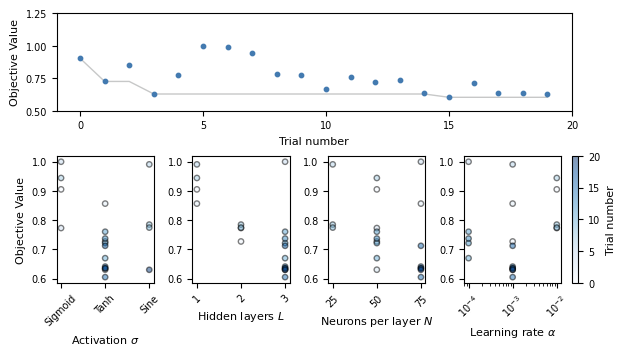

In [ ]:
# ============================
# Extract trial results
# ============================
df = study_loaded.trials_dataframe(attrs=("number", "value", "state"))
df = df[df["state"] == "COMPLETE"]
best_values = df["value"].cummin()

df_params = study_loaded.trials_dataframe(attrs=("number", "value", "params", "state"))
df_params = df_params[df_params["state"] == "COMPLETE"]

params = ["activation", "hidden_layers", "hidden_units", "adam_lr"]

# ============================
# Create figure and gridspec
# ============================
fig = plt.figure(figsize=(7, 3.5))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1.3], hspace=0.4)

# ============================
# Top panel (optimization history)
# ============================
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(df["number"], best_values, color="#c7c8c8ff",
         linewidth=1, label="Best Value", zorder=1)
ax0.scatter(df["number"], df["value"], color="#437ab0ff",
            s=10, label="Objective Value", zorder=2)

ax0.set_ylabel("Objective Value", fontsize=8)
ax0.set_xlabel("Trial number", fontsize=8)

ax0.set_xticks([0, 5, 10, 15, 20])
ax0.set_yticks([0.5, 0.75, 1, 1.25])
ax0.tick_params(axis="y", labelsize=7)
ax0.tick_params(axis="x", labelsize=7)

# Adjust width manually (left, bottom, width, height in figure coordinates)
pos = ax0.get_position()
ax0.set_position([pos.x0, pos.y0, 0.95 * pos.width, pos.height])

# ============================
# Bottom panel (slice plots)
# ============================
gs2 = gs[1].subgridspec(1, len(params), wspace=0.4)
axes = [fig.add_subplot(gs2[0, i]) for i in range(len(params))]

norm = mcolors.Normalize(vmin=0, vmax=20)

for i, p in enumerate(params):
    sc = axes[i].scatter(
        df_params[f"params_{p}"],
        df_params["value"],
        c=df_params["number"],
        cmap="Blues",
        edgecolor="k",
        s=15,
        norm=norm,
        alpha=0.5
    )

    # X labels
    if p == "adam_lr":
        axes[i].set_xlabel(r"Learning rate $\alpha$", fontsize=8)
        axes[i].set_xscale("log")
    elif p == "hidden_layers":
        axes[i].set_xlabel(r"Hidden layers $L$", fontsize=8)
    elif p == "hidden_units":
        axes[i].set_xlabel(r"Neurons per layer $N$", fontsize=8)
        axes[i].set_xticks([25, 50, 75])
    elif p == "activation":
        axes[i].set_xlabel(r"Activation $\sigma$", fontsize=8)

    # Y label only for first plot
    if i == 0:
        axes[i].set_ylabel("Objective Value", fontsize=8)

    # Ticks
    axes[i].tick_params(axis="x", rotation=45, labelsize=7)
    axes[i].tick_params(axis="y", labelsize=7)

# ============================
# Shared colorbar
# ============================
cbar = fig.colorbar(sc, ax=axes,
                    orientation="vertical", fraction=0.05, pad=0.02)
cbar.set_ticks(np.arange(0, 20 + 1, 5))  # ticks cada 5 → incluye el 20
cbar.set_label("Trial number", fontsize=8)
cbar.ax.tick_params(labelsize=7)

# ============================
# Save & show
# ============================
plt.savefig("figures/hyperparameter_tunning.svg", dpi=300, bbox_inches="tight")
plt.savefig("figures/hyperparameter_tunning.pdf", dpi=300, bbox_inches="tight")
plt.show()
